Basic Curved trajectory analysis
================================

The objective of this notebook is to learn how to perform linear (curve) trajectory inference from single cell data, starting from a count matrix. Features that significantly changes along the tree will then be extracted and clustered.


## Preparing the environment for the tutorial

The following needs to be run in the command-line

```bash
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2=3.4.2 -y
conda activate scFates
conda install ipykernel
python -m ipykernel install --user --name scFates --display-name "scFates"
pip install scFates
```

## Importing modules and basic settings

In [1]:
import scanpy as sc
import scFates as scf
import warnings
warnings.filterwarnings("ignore")

adata = sc.read('hgForebrainGlut.loom', backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
adata.var_names_make_unique()
sc.set_figure_params()

In [2]:
import sys
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

## Pre-processing

In [3]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata,base=10)
sc.pp.highly_variable_genes(adata)

filtered out 18081 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
adata.raw=adata

In [5]:
adata=adata[:,adata.var.highly_variable]
sc.pp.scale(adata)
sc.pp.pca(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


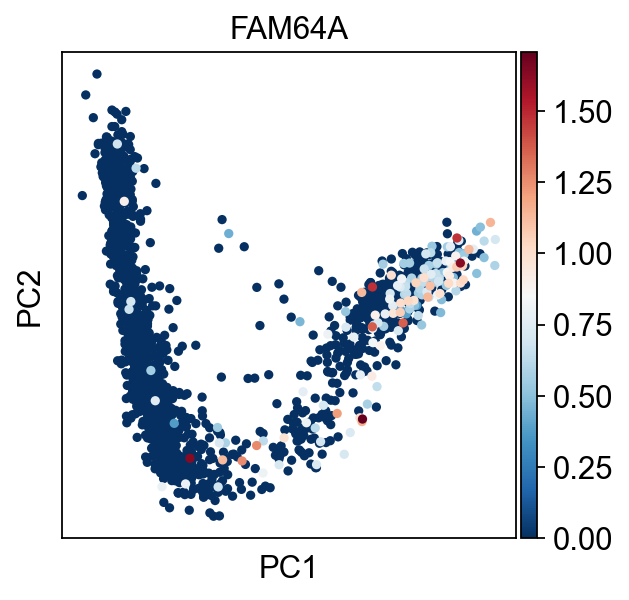

In [6]:
sc.pl.pca(adata,color="FAM64A",cmap="RdBu_r")

## Learn curve using ElPiGraph algorithm

We will infer a principal curve on the 2 first PC components. Any dimensionality reduction in `.obsm` can be selected using `use_rep` parameter, and the number of dimension to retain can be set using `ndims_rep`.

In [7]:
scf.tl.curve(adata,Nodes=30,use_rep="X_pca",ndims_rep=2,)

inferring a principal curve --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


### Plotting the tree

By default the plot function will annotate automatically the tips and the forks ids.

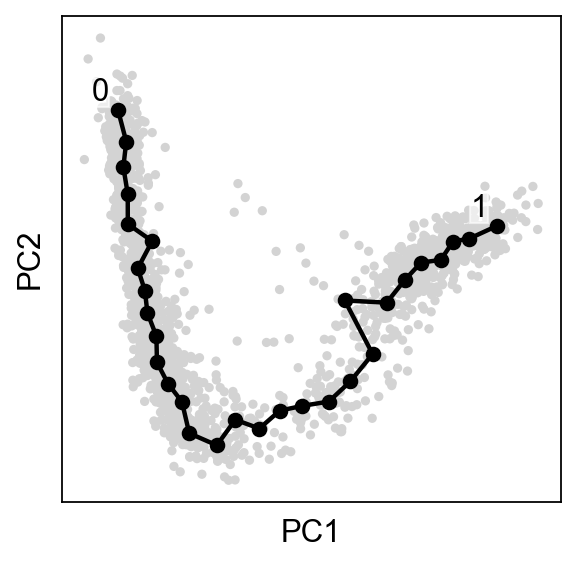

In [8]:
scf.pl.graph(adata,basis="pca")

### Showing hard assignment of cells

Let's show the assignement of cells to the node ID 2:

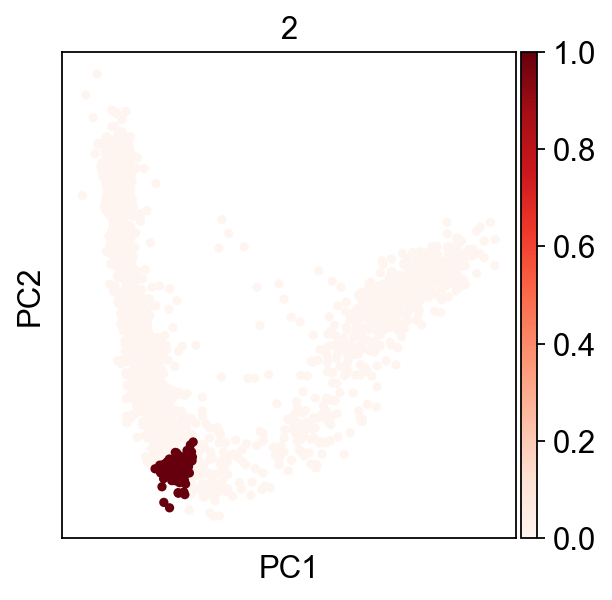

In [9]:
sc.pl.pca(sc.AnnData(adata.obsm["X_R"],obsm=adata.obsm),color="2",cmap="Reds")

Hard assignment is used only when ElPiGraph algorithm is used, as it does not include the concept of soft assigngment.
This means that cells are either assigned a 0 or a 1 toward a given node.

### Hard versus soft assignment

Soft assignment is useful for using probabilistic mapping of cells. To obtain a soft assignment matrix, we can run one or more iterations of SimplePPT algorithm, while keeping the same node graph (no edges are changed, no nodes are added nor removed):

In [10]:
scf.tl.convert_to_soft(adata,1,1000)

Converting R into soft assignment matrix
    finished (0:00:01) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


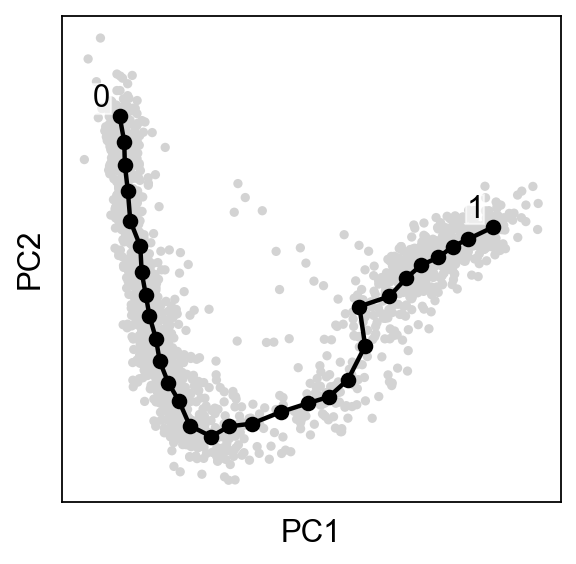

In [11]:
scf.pl.graph(adata,basis="pca")

Now looking at node ID 2 cell assignments, we have continuous values:

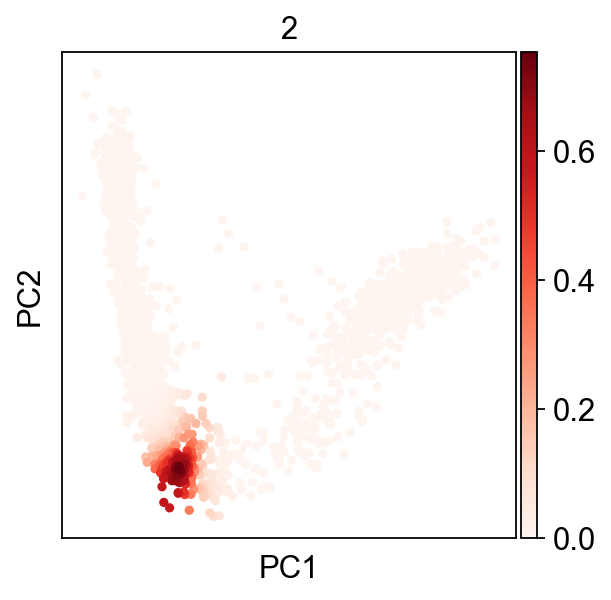

In [12]:
sc.pl.pca(sc.AnnData(adata.obsm["X_R"],obsm=adata.obsm),color="2",cmap="Reds")

We have now cells that are assigned to a node by a value between 0 and 1, which allow us to use probabilistic mappings to accoutn for variability. 

## Selecting a root and computing pseudotime

Using FAM64A marker, we can confidently tell that the tip 1 is the root.

In [13]:
scf.tl.root(adata,"FAM64A")

automatic root selection using FAM64A values
node 1 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Here we are running 100 mappings to account for uncertainty, the pseudotime saved in obs will be the mean  of all computed pseudotimes:

In [14]:
scf.tl.pseudotime(adata,n_jobs=20,n_map=100,seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]
    finished (0:00:27) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


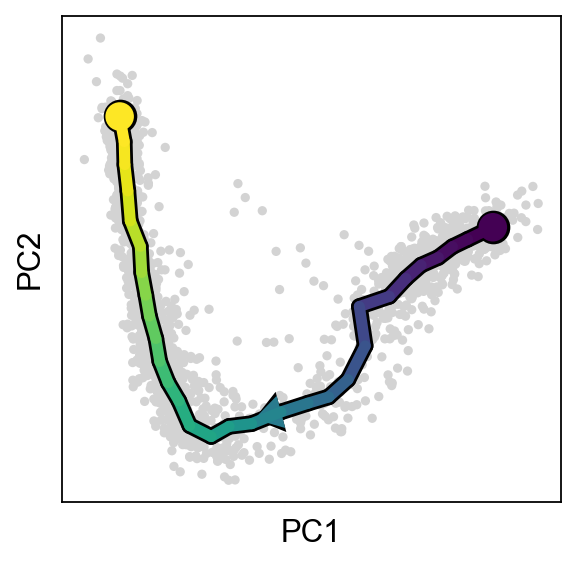

In [15]:
scf.pl.trajectory(adata,basis="pca",arrows=True,arrow_offset=3)

In [16]:
adata=adata.raw.to_adata()

## Linearity deviation assessment

In order to verify that the trajectory we are seeing is not the result of a lienar mixture of two population (caused by doublets), we perform the following test:

Estimation of deviation from linearity
    cells on the bridge: 100%|██████████| 1032/1032 [00:04<00:00, 256.15it/s]


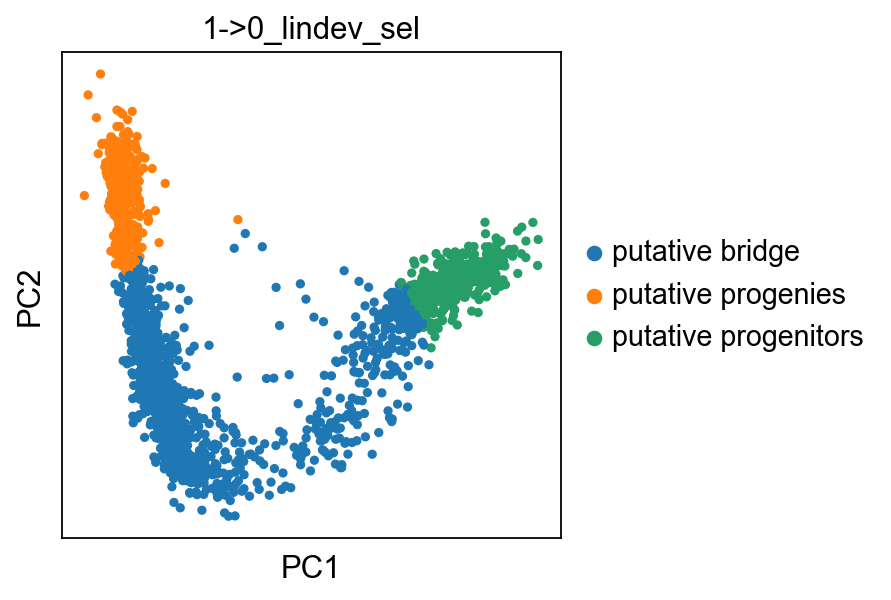

    finished (0:00:05) --> added 
    .var['1->0_rss'], pearson residuals of the linear fit.
    .obs['1->0_lindev_sel'], cell selections used for the test.


In [17]:
scf.tl.linearity_deviation(adata,start_milestone="1",end_milestone="0",n_jobs=20,plot=True,basis="pca")

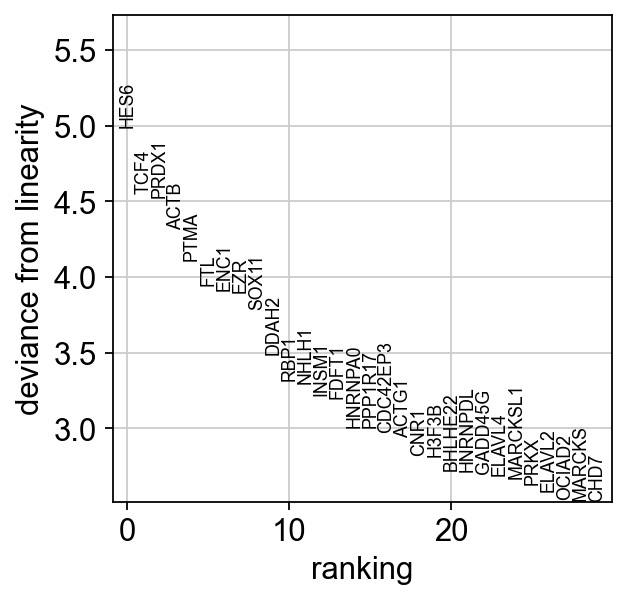

In [18]:
scf.pl.linearity_deviation(adata,start_milestone="1",end_milestone="0")

We have markers that highly deviate from linearity, most of which are biologically relevant. We can confidently say that this is a developmental bridge.

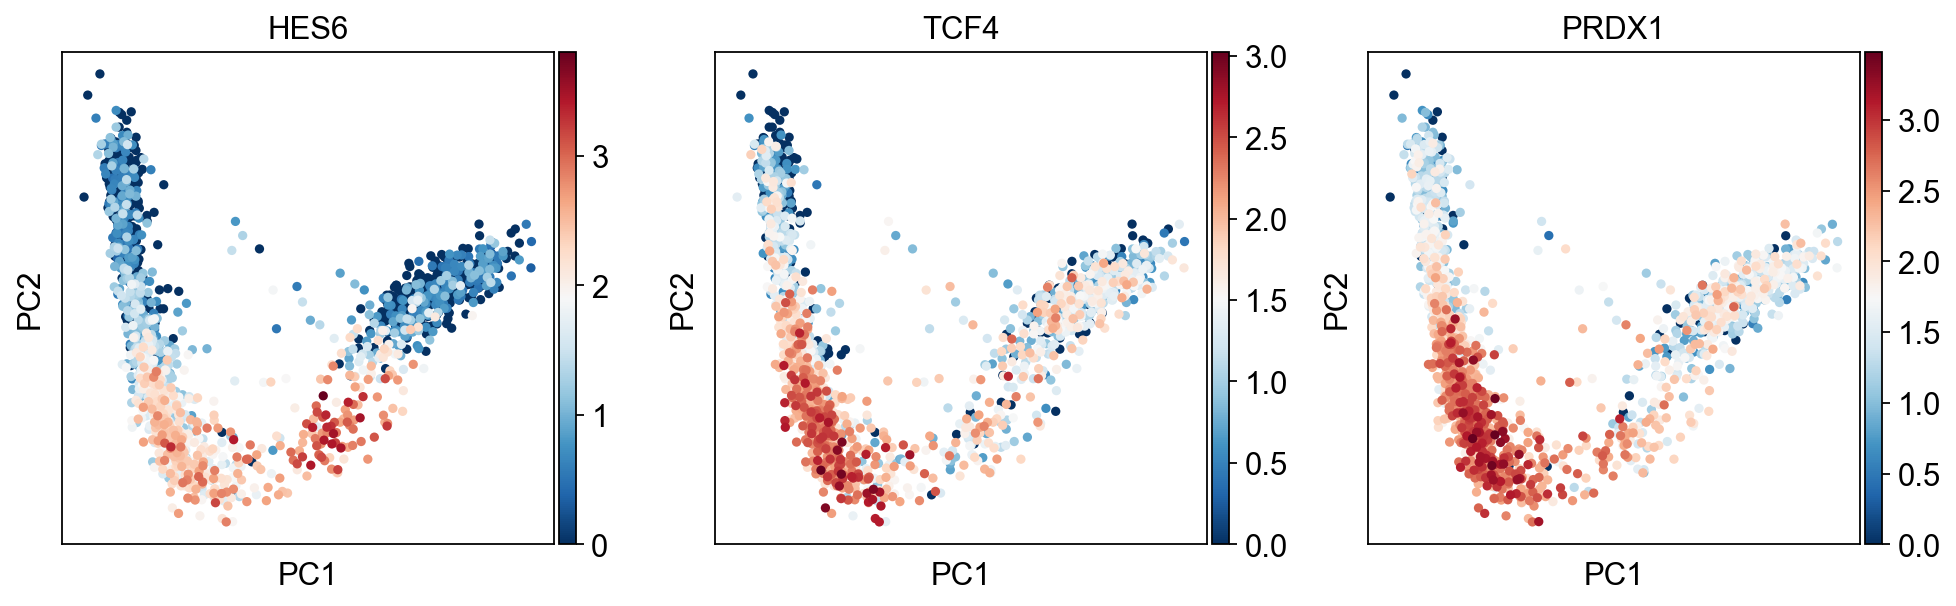

In [19]:
sc.pl.pca(adata,color=["HES6","TCF4","PRDX1"],cmap="RdBu_r")

## Significantly changing feature along pseudotime test

In [20]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 14657/14657 [03:40<00:00, 66.50it/s]
    found 139 significant features (0:03:40) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


We can change the amplitude parameter to get more significant genes, this can be done without redoing all the tests (`reapply_filters` parameter)

reapplied filters, 591 significant features


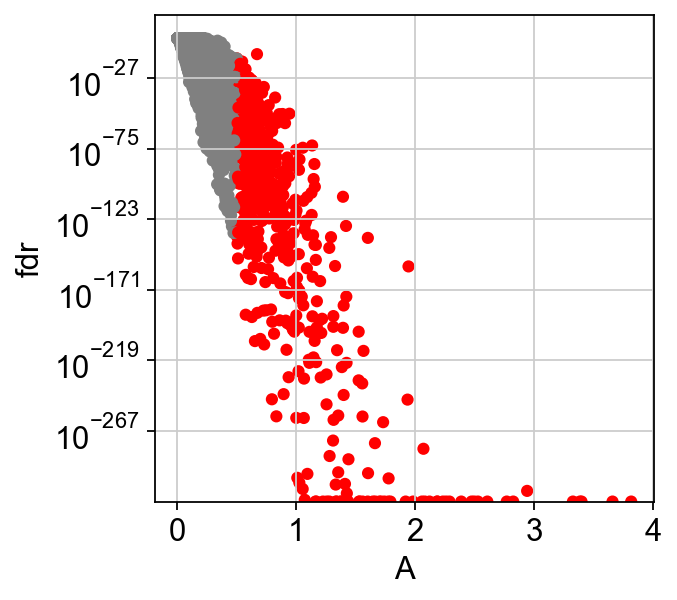

In [21]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=.5)
scf.pl.test_association(adata)

## Fitting & clustering significant features

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw)

</div>

In [22]:
scf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 591/591 [00:16<00:00, 36.29it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:16) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


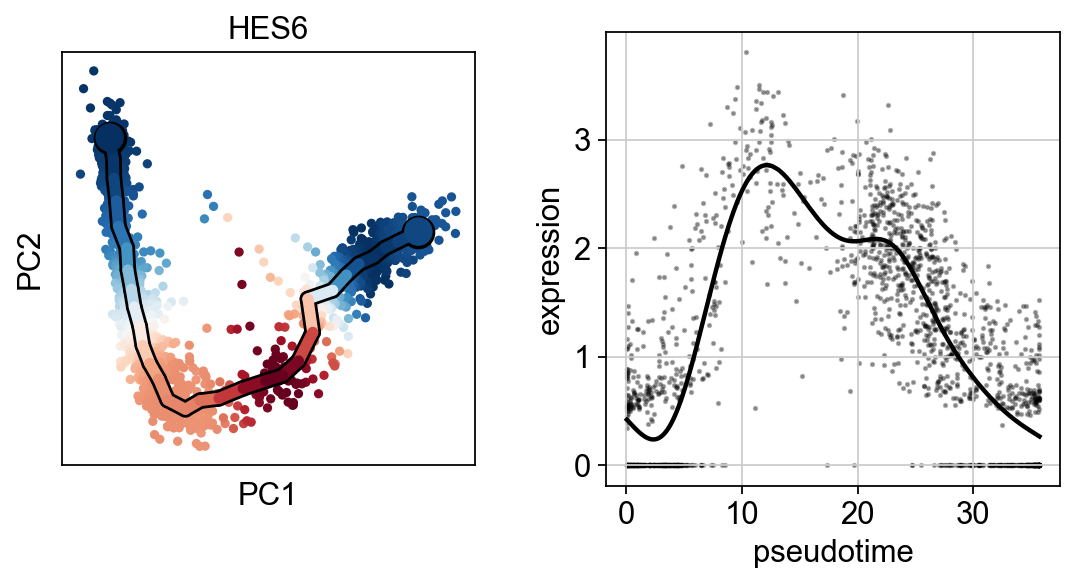

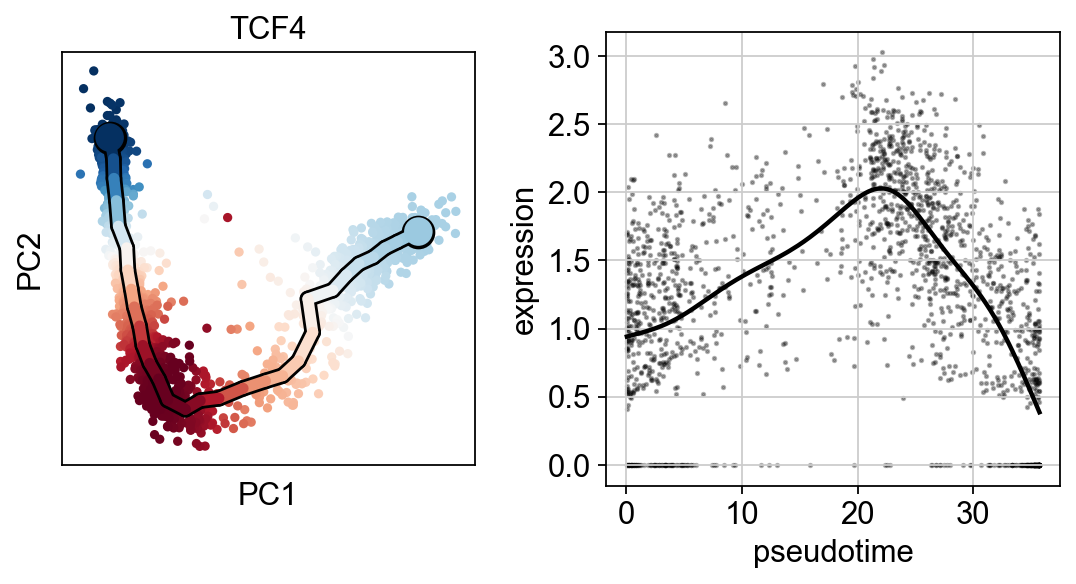

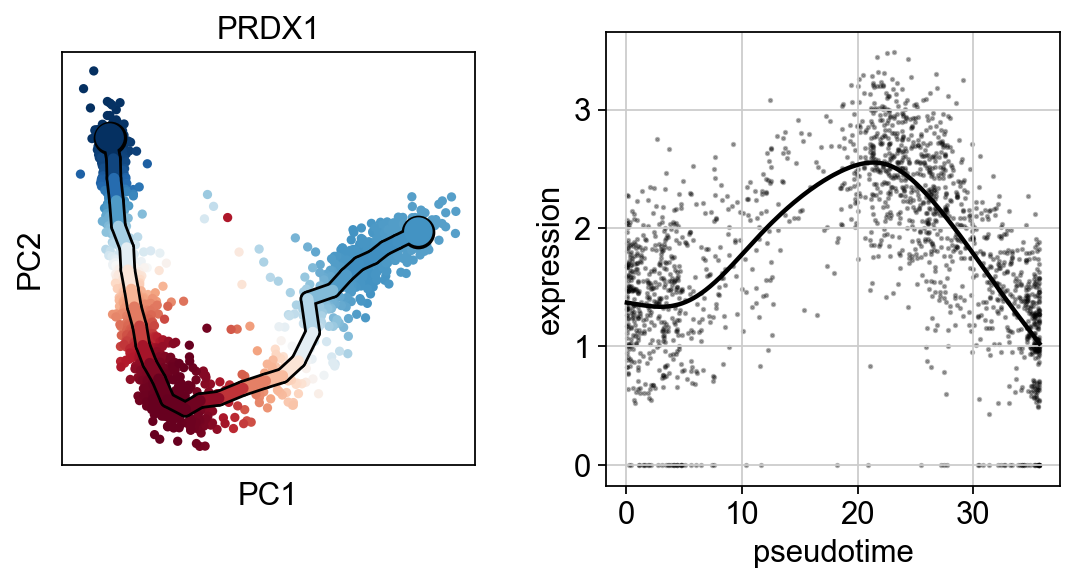

In [23]:
scf.pl.single_trend(adata,"HES6",basis="pca",color_exp="k")
scf.pl.single_trend(adata,"TCF4",basis="pca",color_exp="k")
scf.pl.single_trend(adata,"PRDX1",basis="pca",color_exp="k")

In [24]:
scf.tl.cluster(adata,knn=100,metric="correlation")

    clustering using phenograph
Finding 100 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 0.1490952968597412 seconds
Jaccard graph constructed in 1.8737070560455322 seconds
Wrote graph to binary file in 0.026856422424316406 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.574661
After 2 runs, maximum modularity is Q = 0.577383
Louvain completed 22 runs in 1.6941168308258057 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.668705701828003 seconds
    finished (0:00:08) --> added
    .obsp['similarity'], pairwise similarity graph.
    .var['fit_clusters'], cluster assignments for features.
    .uns['fit_clusters'], parameters and modularity of the clustering.


In [25]:
adata.var.fit_clusters.unique()

array([0, 3, 1, 2, 4])

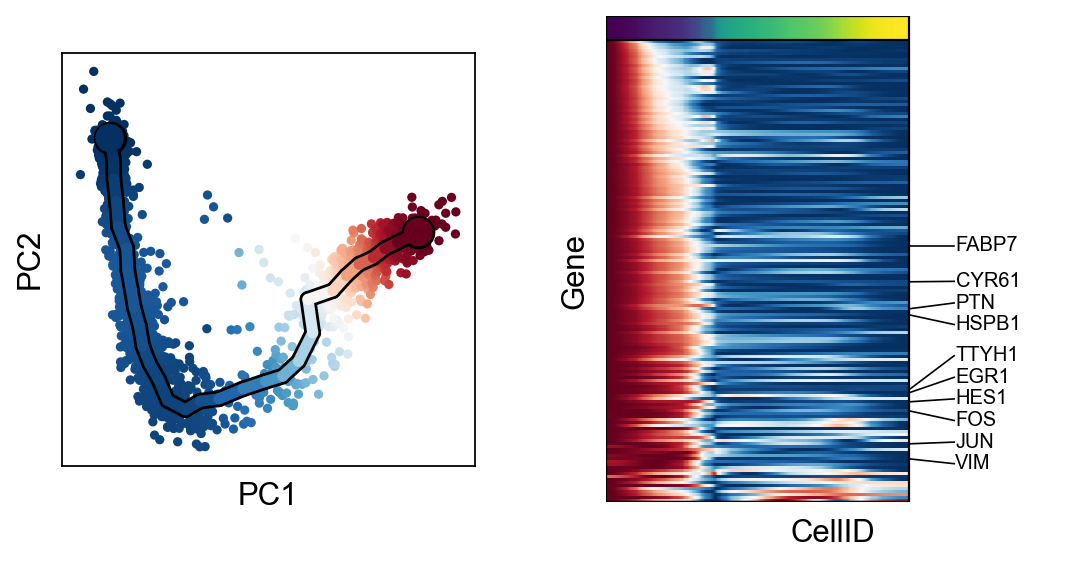

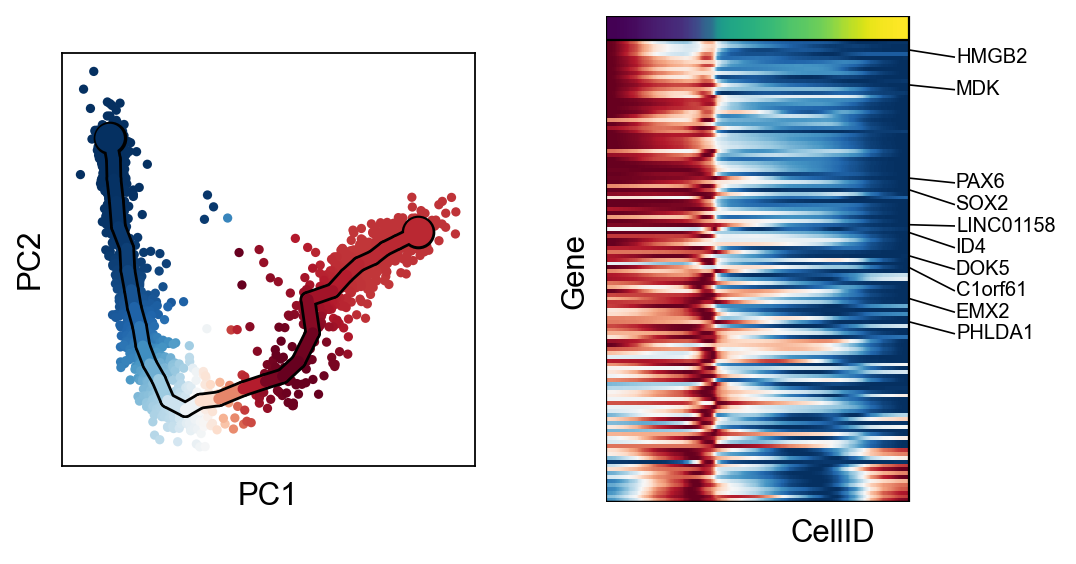

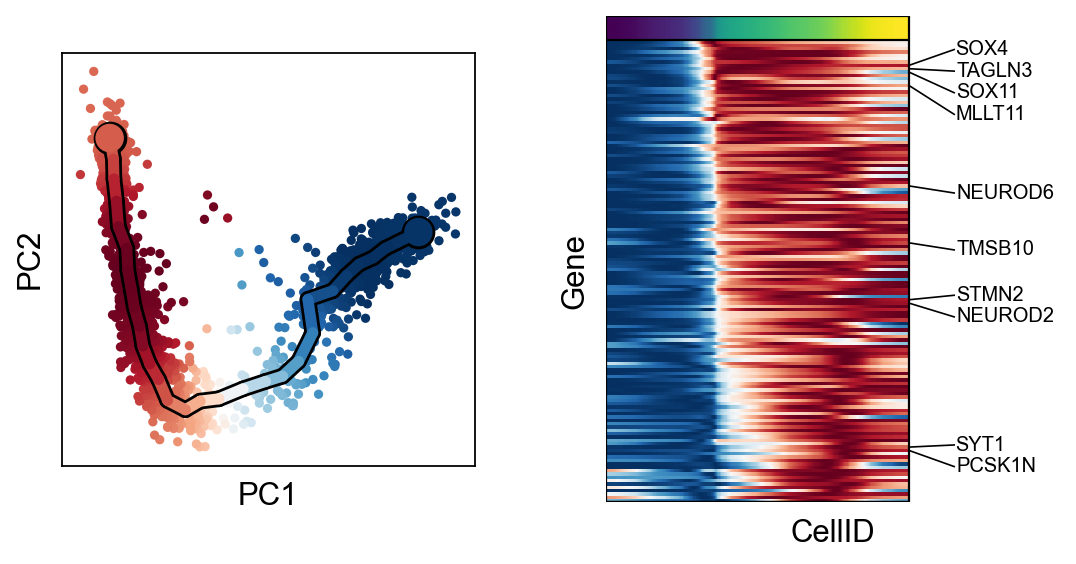

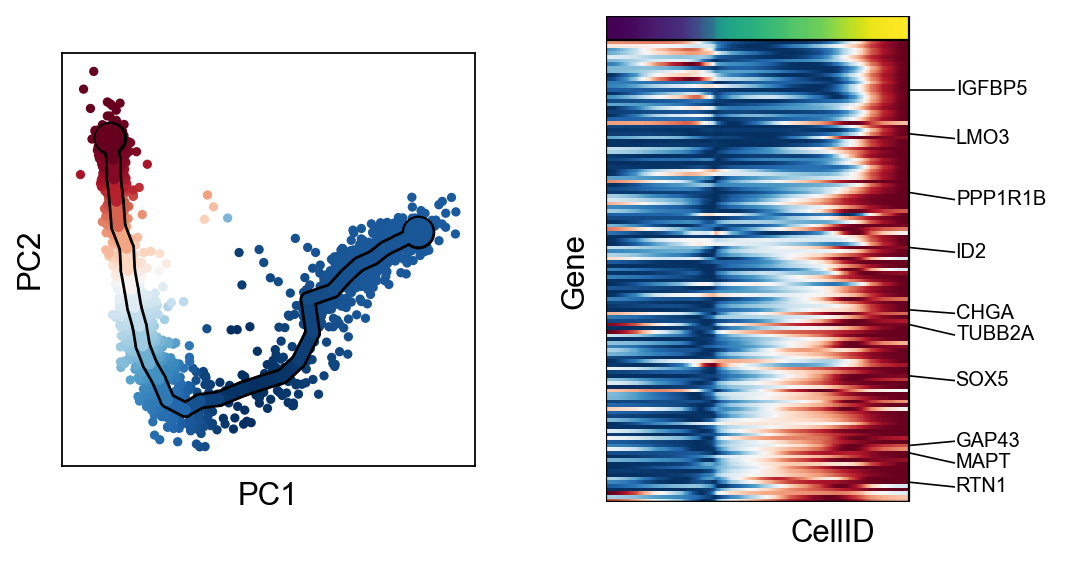

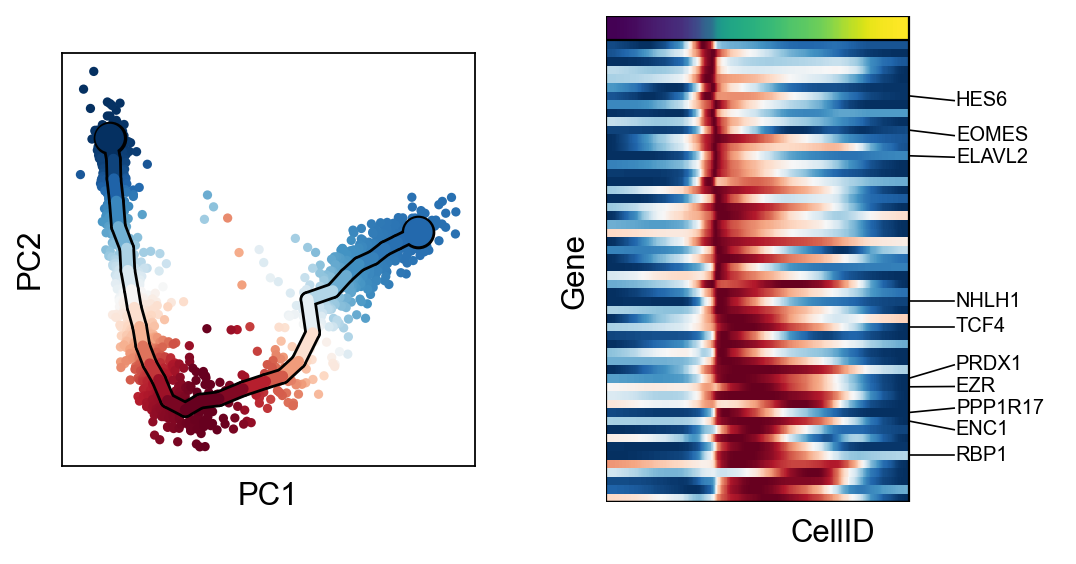

In [26]:
for c in adata.var["fit_clusters"].unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.fit_clusters==c],basis="pca")